In [1]:
import json 
!mkdir -p ~/.kaggle
token = {"username":"seunghwan1228","key":"0f6351758ad29d87352cba99de319590"}
with open('/content/drive/My Drive/Colab Notebooks/Kaggle Kernel/kaggle.json', 'w') as file:
  json.dump(token, file)
!cp drive/'My Drive'/'Colab Notebooks'/'Kaggle Kernel'/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json

kaggle.json
total 4
-rw------- 1 root root 72 Feb 18 01:24 kaggle.json
{"username": "seunghwan1228", "key": "0f6351758ad29d87352cba99de319590"}

In [2]:
!kaggle datasets list -s CelebFaces

ref                           title                                   size  lastUpdated          downloadCount  
----------------------------  --------------------------------------  ----  -------------------  -------------  
jessicali9530/celeba-dataset  CelebFaces Attributes (CelebA) Dataset   1GB  2018-06-01 20:08:48          23614  


In [3]:
!kaggle datasets download jessicali9530/celeba-dataset

 99% 1.32G/1.33G [00:17<00:00, 114MB/s] 
100% 1.33G/1.33G [00:17<00:00, 80.3MB/s]


In [4]:
!nohup unzip celeba-dataset.zip

nohup: ignoring input and appending output to 'nohup.out'


# Import Moduels

In [5]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import IPython
from tqdm import tqdm, tqdm_notebook

warnings.filterwarnings('ignore')

TensorFlow 2.x selected.


In [0]:
img_dir = '/content/img_align_celeba/img_align_celeba'

In [7]:
print('Image files are : ', len(os.listdir(img_dir)))
print('Sample Image : ', os.listdir(img_dir)[0])

Image files are :  202599
Sample Image :  185903.jpg


In [0]:
# Requires function to read the jpg and convert to array
def image_load(path):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img)

  img = tf.cast(img, tf.float32)
  return img

In [0]:
# Requires to resize the image
def resize_img(image):
  img = tf.image.resize(image, size=(256, 256), method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return img

In [0]:
def normalize(image):
  img = (image / 255.)
  return img

In [0]:
dataset = tf.data.Dataset.list_files(img_dir + '/*.jpg')
dataset = dataset.map(image_load)
dataset = dataset.map(resize_img)
dataset = dataset.map(normalize)
dataset = dataset.batch(32)
dataset = dataset.prefetch(3)

tf.Tensor(
[[[0.62352943 0.78039217 0.88235295]
  [0.62352943 0.78039217 0.88235295]
  [0.62352943 0.78039217 0.88235295]
  ...
  [0.99215686 0.9882353  1.        ]
  [0.99215686 0.9882353  1.        ]
  [0.99215686 0.9882353  1.        ]]

 [[0.62352943 0.7647059  0.8980392 ]
  [0.61960787 0.77254903 0.89411765]
  [0.61960787 0.77254903 0.89411765]
  ...
  [0.99215686 0.99215686 1.        ]
  [0.99215686 0.99215686 1.        ]
  [0.99215686 0.99215686 1.        ]]

 [[0.6156863  0.74509805 0.92156863]
  [0.6156863  0.7529412  0.91764706]
  [0.6156863  0.7529412  0.91764706]
  ...
  [0.9882353  1.         0.972549  ]
  [0.9882353  1.         0.972549  ]
  [0.9882353  1.         0.972549  ]]

 ...

 [[0.05098039 0.10196079 0.16470589]
  [0.05490196 0.10196079 0.15686275]
  [0.05490196 0.10196079 0.15686275]
  ...
  [0.91764706 0.34509805 0.4862745 ]
  [0.91764706 0.34509805 0.4862745 ]
  [0.8784314  0.24313726 0.40392157]]

 [[0.03137255 0.08627451 0.13725491]
  [0.03529412 0.08235294 0

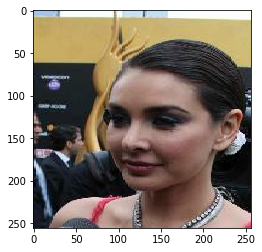

In [12]:
# check dataset

for n, i in enumerate(dataset.take(2)):
  IPython.display.clear_output(wait=True)

  print(i[0])
  print(i[0].shape)
  # test_img = plt.imread(i[0].numpy())
  plt.imshow(i[0].numpy())
  np.save(f'test_{n}', i.numpy())
  
  if n == 2:
    break

In [0]:
# Generator

class down_sample(tf.keras.layers.Layer):
  def __init__(self, filters, kernel_size, is_bn = True, is_dr = True):
    super(down_sample, self).__init__()
    self.filters = filters
    self.kernel_size = kernel_size
    self.is_bn = is_bn
    self.is_dr = is_dr
    self.conv = tf.keras.layers.Conv2D(self.filters, 
                                       self.kernel_size, 
                                       strides=2, 
                                       padding='same', 
                                       kernel_initializer=tf.keras.initializers.RandomNormal(0., 0.02),
                                       use_bias=False)
    self.bn = tf.keras.layers.BatchNormalization()
    self.activation = tf.keras.layers.LeakyReLU()
    self.dropout = tf.keras.layers.Dropout(0.5)
  
  def call(self, x):
    x = self.conv(x)
    if self.is_bn:
      x = self.bn(x)
    x = self.activation(x)
    if self.dropout:
      x = self.dropout(x)
    return x



class up_sample(tf.keras.layers.Layer):
  def __init__(self, filters, kernel_size, is_bn = True, is_dr = True):
    super(up_sample, self).__init__()
    self.filters = filters
    self.kernel_size = kernel_size
    self.is_bn = is_bn
    self.is_dr = is_dr

    self.convt = tf.keras.layers.Conv2DTranspose(self.filters, 
                                                 self.kernel_size, 
                                                 strides=2,
                                                 padding='same',
                                                 kernel_initializer=tf.keras.initializers.RandomNormal(0., 0.02),
                                                 use_bias=False)
    self.bn = tf.keras.layers.BatchNormalization()
    self.activation = tf.keras.layers.LeakyReLU()
    self.dropout = tf.keras.layers.Dropout(0.5)

  def call(self, x):
    x = self.convt(x)
    if self.is_bn:
      x = self.bn(x)
    x = self.activation(x)
    if self.is_dr:
      x = self.dropout(x)
    return x

In [0]:
def Generator():
  init = tf.keras.initializers.RandomNormal(0., 0.02)

  inputs = tf.keras.layers.Input(shape=(100, ))
  x = tf.keras.layers.Dense(256*256*3, use_bias=False)(inputs)
  x = tf.keras.layers.Reshape((256, 256, 3))(x)

  # 128, 128, 64
  # 64, 64, 128
  # 32, 32, 256
  # 16, 16, 512
  # 8, 8, 512
  # 4, 4, 512
  # 2, 2, 512

  # 1, 1, 512
  down_list = [down_sample(64, 4, is_bn=False, is_dr=False),
               down_sample(128, 4),
               down_sample(256, 4),
               down_sample(512, 4),
               down_sample(512, 4),
               down_sample(512, 4),
               down_sample(512, 4),

               down_sample(512, 4)]
  # 2, 2, 512
  # 4, 4, 512
  # 8, 8, 512
  # 16, 16, 512
  # 32, 32, 256
  # 64, 64, 128
  # 128, 128, 64
  up_list = [up_sample(512, 4),
             up_sample(512, 4),
             up_sample(512, 4),
             up_sample(512, 4),
             up_sample(256, 4),
             up_sample(128, 4),
             up_sample(64, 4),     
             ]


  skip = []
  for down in down_list:
    x = down(x)
    skip.append(x)

  skip = reversed(skip[:-1])

  for up, skip in zip(up_list, skip):
    x = up(x)
    x = tf.keras.layers.Concatenate()([skip, x])
  
  x = tf.keras.layers.Conv2DTranspose(3, 
                                      4, 
                                      strides=2, 
                                      padding='same', 
                                      activation='tanh', 
                                      kernel_initializer=init, 
                                      use_bias=False)(x)


  return tf.keras.models.Model(inputs, x)

In [15]:
tf.keras.backend.clear_session()
checker = Generator()
checker.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 196608)       19660800    input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 256, 256, 3)  0           dense[0][0]                      
__________________________________________________________________________________________________
down_sample (down_sample)       (None, 128, 128, 64) 3072        reshape[0][0]                    
______________________________________________________________________________________________

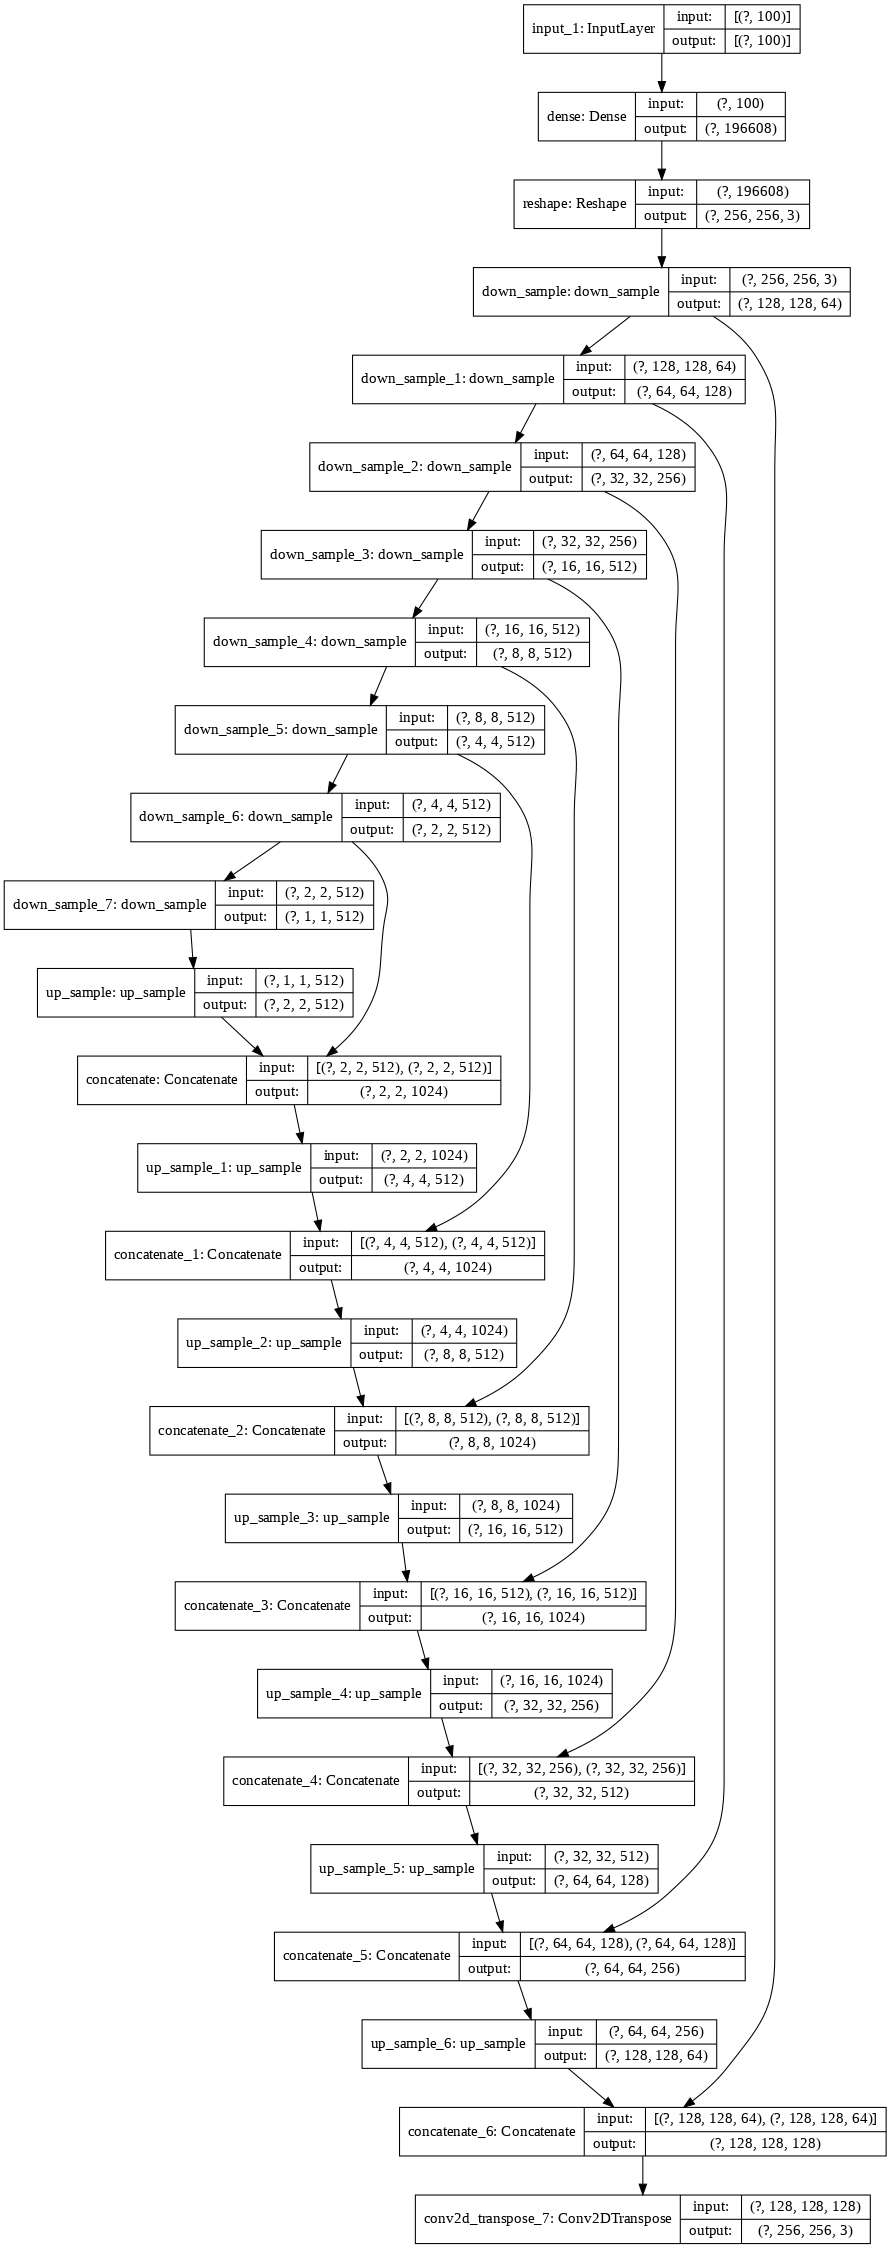

In [16]:
tf.keras.utils.plot_model(checker, show_shapes=True, dpi=76)

In [0]:
def Discriminator():
  init = tf.keras.initializers.RandomNormal(0., 0.02)
  inputs = tf.keras.layers.Input(shape=(256, 256, 3))

  x = down_sample(64, 4, is_bn=False, is_dr=False)(inputs)
  x = down_sample(128, 4)(x)
  x = down_sample(256, 4)(x)
  x = down_sample(512, 4)(x)
  x = down_sample(512, 4)(x)
  x = down_sample(512, 4)(x)

  x = tf.keras.layers.Flatten()(x)

  x = tf.keras.layers.Dense(1)(x)
  return tf.keras.models.Model(inputs, x)

In [0]:
generator = Generator()
discriminator = Discriminator()


generator_optimizer = tf.keras.optimizers.Adam(1e-4, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, 0.5)

In [19]:
generator.output_shape

(None, 256, 256, 3)

In [20]:
discriminator.output_shape

(None, 1)

In [0]:
EPOCH = 100 #@param
noise_dim = 100 #@param
num_examples_to_generate = 16 #@param
seed = tf.random.normal([num_examples_to_generate, noise_dim])
BATCH_SIZE=32 #@param


In [0]:
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)

@tf.function
def generator_loss(gen_output):
  gen_loss = loss_function(tf.ones_like(gen_output), gen_output)
  return gen_loss


@tf.function
def discriminator_loss(real_output, fake_output):
  real_loss = loss_function(tf.ones_like(real_output), real_output)
  fake_loss = loss_function(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [0]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, 100])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_image = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_image, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
  
  gen_g = gen_tape.gradient(gen_loss, generator.trainable_variables)
  disc_g = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gen_g, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(disc_g, discriminator.trainable_variables))

In [0]:
def generate_image(model, epoch, test_input):
  predictions = model(test_input, training=False)
  predictions = predictions[:16]

  fig = plt.figure(figsize=(8,8))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, :])
    plt.axis('off')
  
  plt.show()

In [0]:
def train(dataset, epochs):
  
  for i in range(epochs):
    IPython.display.clear_output(wait=True)
    generate_image(generator, i, seed)
    print(f'Epochs : {i+1}')

    for image in tqdm_notebook(dataset):
      train_step(image)
    
    IPython.display.clear_output(wait=True)
    generate_image(generator, i, seed)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

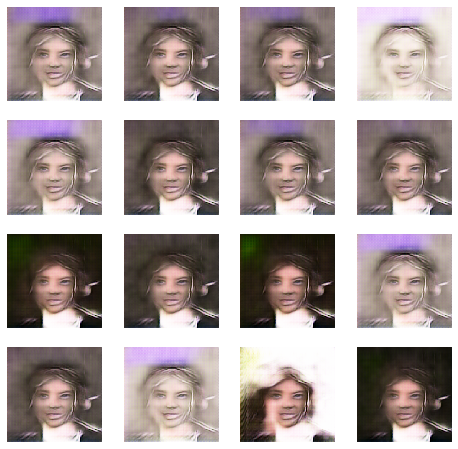

Epochs : 6


KeyboardInterrupt: ignored

In [26]:
train(dataset, 100)

In [0]:
test_1 = np.load('/content/test_0.npy')
test_2 = np.load('/content/test_1.npy')

In [0]:
# read multiple numpy files with tf 

npy_files = ['/content/test_0.npy', '/content/test_1.npy']

test_dataset = tf.data.Dataset.list_files(npy_files)

@tf.function
def read_npy(file_):
  files = file_
  # files = tf.strings.unicode_encode(files, 'utf-8')
  # loading = np.load(files)
  return files

test_dataset = test_dataset.map(read_npy)

In [0]:
# check dataset

for n, i in enumerate(test_dataset.take(1)):
  IPython.display.clear_output(wait=True)

  print(i)
  print(i.shape)
  # test_img = plt.imread(i[0].numpy())
  # plt.imshow(i.numpy())
  # np.save(f'test_{n}', i.numpy())
  
  if n == 1:
    break

tf.Tensor(b'/content/test_0.npy', shape=(), dtype=string)
()


b'/content/test_0.npy'